In [55]:
import pandas as pd

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt

from copia.data import to_copia_dataset
from copia.estimators import diversity
from copia.rarefaction_extrapolation import species_accumulation
from copia.plot import accumulation_curve

More generally, I would like to see a robustness analysis on the estimator - this is an active area of research. IE use several different estimator methods and show the result is not dependent on which one is used.

At a minimum I would like to see that results don't (or possibly do which would require explanation) using Chao1 and Generalized Chao. As best I can tell more recent methods like Alroy's [2008] method for correcting for recency bias wouldn't work, but there are a lot of choices out there. This is supplemental material, but important. It would be required in my field. 

--> By robustness analysis, we understand that the reviewer requests a formal comparison of different estimators. In copia, a diverse set of alternative estimators have already been implemented (such as the jackknife): if we would bin, for instance, the producers by occupation level, we could run these on the groups in isolation and compare them the results of the Generalized Chao. [MIKE] [2h]


Formal comparison of different estimators

1) Chao1 
2) Generalized  [Already implemented]
3) Jacknife (if we would bin, for instance, the producers by occupation level, we could run these on the groups in isolation and compare them the results of the Generalized Chao.) - https://github.com/mikekestemont/copia

Copia is a statistical software package for estimating diversity and richness on the basis of abundance data. The package contains several bias-correcting richness estimators, such as the Chao1 and the Jacknife estimator.

### Testing

chao1 -> 6
ichao1 -> 6
ace -> 7
jackknife -> 6
egghe_proot -> 6


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

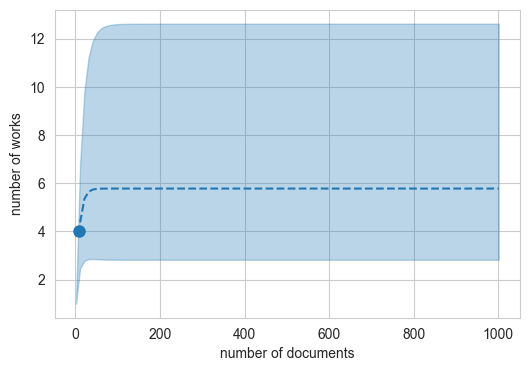

In [56]:
observations = 'duck', 'duck', 'eagle', 'dove', 'dove', 'dove', 'hawk', 'dove', 'dove'
ds = to_copia_dataset(observations, data_type="abundance", input_type="observations")

for method in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    print(method, '->', round(diversity(ds, method=method)))

D = diversity(ds, method='chao1', CI=True, n_iter=100, n_jobs=1)

accumulation = species_accumulation(ds, max_steps=1000, n_iter=100, step_size=10)
fig, ax = plt.subplots(figsize=(6, 4))

accumulation_curve(
    ds, accumulation, ax=ax, xlabel="number of documents", ylabel="number of works");

#### Apply on normal data

In [57]:
df = pd.read_csv('unseen_species_model/unseen_species_model_bayesian.csv')
df

,Unnamed: 0,individual_wikidata_id,decade,region_name,count_works,occupation,century,count,y,y_mean,y_min,y_max,f0,max_f0,min_f0,f1,f2
0,0,Q1000034,1850,German world,0.00,Writer,1800,0.00,0,0.03,0.03,0.03,18.01,18.90,17.20,1,0
1,2,Q1000034,1850,Northwestern Europe,0.00,Writer,1800,0.00,0,0.04,0.04,0.04,11.72,12.07,11.38,1,0
2,5,Q100022441,1770,France,0.00,Performing Artist,1800,0.00,0,0.04,0.04,0.05,10.51,11.64,9.56,1,0
3,6,Q100022441,1770,Northwestern Europe,0.00,Performing Artist,1800,0.00,0,0.04,0.03,0.04,13.11,14.43,11.98,1,0
4,9,Q100028706,1880,Italy,0.00,Musician,1900,0.00,0,0.00,0.00,0.01,107.03,121.08,95.72,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201238,474175,Q99982212,1880,Central Europe,0.00,Architect,1900,0.00,0,0.01,0.01,0.01,39.13,44.12,34.93,1,0
201239,474181,Q999920,1790,German world,2.00,Painter,1800,2.00,1,0.07,0.07,0.07,6.28,6.60,5.98,0,1
201240,474182,Q999920,1790,Northwestern Europe,2.00,Painter,1800,2.00,1,0.10,0.10,0.10,4.00,4.14,3.86,0,1
201241,474184,Q999983,1340,France,0.00,Writer,1300,0.00,0,0.07,0.07,0.08,6.05,6.66,5.52,1,0


In [58]:


df["count"] = df["count_works"].copy()
df['count'] = df['count'].astype(int)
sample = df.copy()
sample = sample[sample["count"].isin({0, 1, 2})]  # Not more ?
sample["y"] = sample["count"].map({0: 0, 1: 0, 2: 1})


#sample = sample.sample(2000, random_state=42)

sample['count'][sample['count']==0] = 1

df_copia = sample[['individual_wikidata_id', 'count']].copy().drop_duplicates()
individual_counts = df_copia.set_index('individual_wikidata_id')['count']
individual_counts.index.name = None

for region in sample.region_name.unique():

    print(region)

    df_copia = sample[['individual_wikidata_id', 'count', 'region_name']].copy().drop_duplicates()
    df_copia = df_copia[df_copia['region_name']==region]
    individual_counts = df_copia.set_index('individual_wikidata_id')['count']
    individual_counts.index.name = None
    ds = to_copia_dataset(individual_counts, data_type="abundance", input_type="counts")

    method = 'jackknife'
    # method='chao1'
    res = ds.S_obs/(ds.S_obs + round(diversity(ds, method=method)))
    print(round(res, 2))
    # for method in ('chao1', 'jackknife'):
    #     print(method, '->', round(diversity(ds, method=method)))




import warnings

# Option 1: Filter this specific warning message
warnings.filterwarnings("ignore", message="Add-one smoothing for f4 = 0")
warnings.filterwarnings("ignore", category=FutureWarning)


# Initialize results list
results = []

# Process each region separately
for region in sample['region_name'].unique():
    region_data = sample[sample['region_name'] == region]
    
    # Get min and max decades for this region
    min_decade = region_data['decade'].min()
    max_decade = region_data['decade'].max()
    
    # Create 10 equal time bins
    time_range = max_decade - min_decade
    bin_size = time_range / 10
    
    # Create custom bins
    bins = [min_decade + i * bin_size for i in range(11)]
    labels = [i for i in range(10)]
    
    # Apply the custom binning
    region_data['time_period'] = pd.cut(region_data['decade'], 
                                         bins=bins, 
                                         labels=labels, 
                                         include_lowest=True)
    
    # Group by time period and occupation
    groups = region_data.groupby(['time_period', 'occupation'])
    
    # Iterate through each group
    for (time_period, occupation), group_data in groups:
        # Get counts for unique individuals in this group
        df_unique = group_data[['individual_wikidata_id', 'count']].drop_duplicates()

        individual_counts = df_unique.set_index('individual_wikidata_id')['count']
        individual_counts.index.name = None
        ds = to_copia_dataset(individual_counts, data_type="abundance", input_type="counts")

    
        chao1 = round(diversity(ds, method='chao1'))
        jackknife =  round(diversity(ds, method='jackknife'))
        ichao1 =  round(diversity(ds, method='ichao1'))
        # ace =  round(diversity(ds, method='ace'))
        # egghe_proot=  round(diversity(ds, method='egghe_proot')) #not stable
            
        # # Calculate Chao1 statistics
        # stats = calculate_chao1(counts)
        
        # Add to results
        results.append({
            'region_name': region,
            'decade_binned': time_period,
            'occupation': occupation,
            'f1': ds.f1,
            'f2': ds.f2,
            'n': ds.n,
            'chao1': chao1,
            'jackknife':jackknife,
            'ichao1':ichao1,
            # 'ace':ace,
            # 'egghe_proot':egghe_proot

        })

# Create DataFrame from results
df_estimator = pd.DataFrame(results)

# Sort by region, time period, occupation
df_estimator = df_estimator.sort_values(['region_name', 'decade_binned', 'occupation'])

df_estimator


German world
0.34
Northwestern Europe
0.34
France
0.34
Italy
0.34
Southwestern Europe
0.34
Low countries
0.34
Central Europe
0.34
Arabic world
0.34
United Kingdom
0.34
Spain
0.34
Nordic countries
0.34
East Slavic
0.34
Indian world
0.34
Persian world
0.34
Japan
0.34
Portugal
0.34
Greek World
0.34
Northern China
0.35
Chinese world
0.34
Southern Japan
0.34
Southern China
0.35
Latin World
0.35
Northern Japan
0.34
Korea
0.34


,region_name,decade_binned,occupation,f1,f2,n,chao1,jackknife,ichao1
275,Arabic world,0,Painter,1,0,1,1,1,1
276,Arabic world,0,Writer,1,0,1,1,1,1
277,Arabic world,1,Painter,1,0,1,1,1,1
278,Arabic world,1,Performing Artist,1,0,1,1,1,1
279,Arabic world,1,Writer,22,5,32,74,49,74
...,...,...,...,...,...,...,...,...,...
336,United Kingdom,9,Musician,1069,10,1089,58165,2148,58165
337,United Kingdom,9,Painter,1839,234,2307,9296,3912,9296
338,United Kingdom,9,Performing Artist,186,10,206,1917,382,1917
339,United Kingdom,9,Sculptor,291,45,381,1274,627,1274


In [59]:
import warnings

# Filter specific warnings
warnings.filterwarnings("ignore", message="Add-one smoothing for f4 = 0")
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize results list
results = []

# Process each region separately
for region in sample['region_name'].unique():
    region_data = sample[sample['region_name'] == region]
    
    # Group by decade and occupation directly (no binning)
    groups = region_data.groupby(['decade', 'occupation'])
    
    # Iterate through each group
    for (decade, occupation), group_data in groups:
        # Get counts for unique individuals in this group
        df_unique = group_data[['individual_wikidata_id', 'count']].drop_duplicates()
        
        individual_counts = df_unique.set_index('individual_wikidata_id')['count']
        individual_counts.index.name = None
        ds = to_copia_dataset(individual_counts, data_type="abundance", input_type="counts")
        
        chao1 = round(diversity(ds, method='chao1'))
        jackknife = round(diversity(ds, method='jackknife'))
        ichao1 = round(diversity(ds, method='ichao1'))
        # ace = round(diversity(ds, method='ace'))
        # egghe_proot = round(diversity(ds, method='egghe_proot')) #not stable
        
        # Add to results
        results.append({
            'region_name': region,
            'decade': decade,  # Use actual decade instead of binned value
            'occupation': occupation,
            'f1': ds.f1,
            'f2': ds.f2,
            'n': ds.n,
            'chao1': chao1,
            'jackknife': jackknife,
            'ichao1': ichao1,
            # 'ace': ace,
            # 'egghe_proot': egghe_proot
        })

# Create DataFrame from results
df_estimator = pd.DataFrame(results)

# Sort by region, decade, occupation
df_estimator = df_estimator.sort_values(['region_name', 'decade', 'occupation'])

df_estimator

,region_name,decade,occupation,f1,f2,n,chao1,jackknife,ichao1
2567,Arabic world,-610,Writer,1,0,1,1,1,1
2568,Arabic world,-400,Painter,1,0,1,1,1,1
2569,Arabic world,-360,Painter,1,0,1,1,1,1
2570,Arabic world,-360,Writer,1,1,3,2,3,2
2571,Arabic world,-330,Writer,0,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...
3075,United Kingdom,1880,Musician,170,2,174,7355,342,7355
3076,United Kingdom,1880,Painter,377,37,451,2330,791,2330
3077,United Kingdom,1880,Performing Artist,33,1,35,563,67,563
3078,United Kingdom,1880,Sculptor,17,9,35,42,43,42


In [60]:
df_plot = df.copy()
df_plot = df_plot[['region_name', 'decade', 'occupation', 'f1', 'f2', 'f0']]
df_plot = df_plot.rename(columns={'f0':'gen_chao'})
df_plot = df_plot.groupby(['region_name','decade', 'occupation']).sum().reset_index()
df_plot = pd.merge(df_plot, df_estimator, on = ['region_name', 'decade', 'occupation', 'f1', 'f2'])
df_compare = df_plot.groupby('region_name')[['chao1', 'gen_chao', 'jackknife']].sum().reset_index()
df_compare

,region_name,chao1,gen_chao,jackknife
0,Arabic world,7317,10982.47,1687
1,Central Europe,231145,335122.60,14326
2,Chinese world,14139,10642.89,2269
3,East Slavic,72309,102486.42,6540
4,France,229179,264993.42,32301
5,German world,1060441,932919.97,53619
6,Greek World,6241,14552.38,1489
7,Indian world,1593,3465.36,543
8,Italy,307258,412531.39,24455
9,Japan,6325,8487.41,1339


In [61]:
df_regions = df_plot.groupby(['region_name', 'decade'])[['chao1', 'gen_chao', 'jackknife']].sum().reset_index()

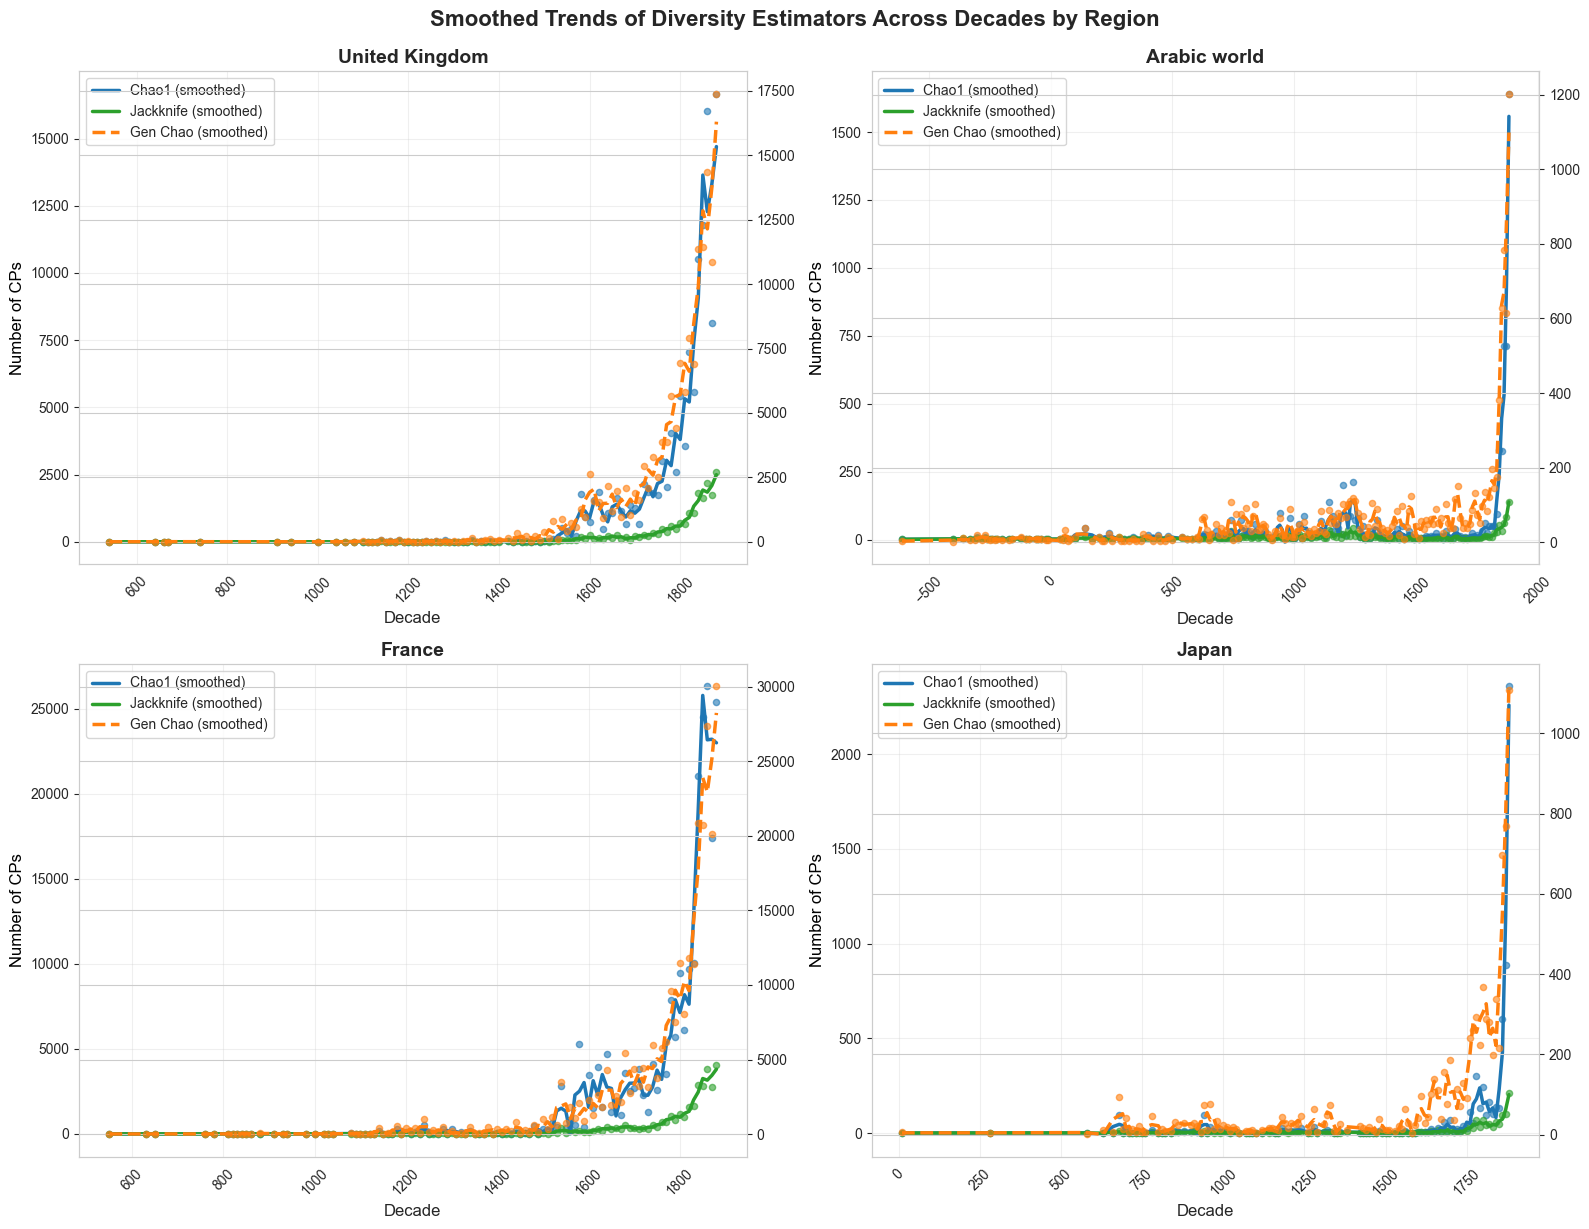

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.signal import savgol_filter

# Assuming df_regions is your dataframe as shown in the image
# Select 4 interesting regions - for example:
regions_to_plot = ['United Kingdom', 'Arabic world', 'France', 'Japan']  # You can change these

# Create a figure with subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=False)
axes = axes.flatten()

# Set a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Function to apply smoothing
def smooth_data(y, window_size=5, poly_order=2):
    """Apply Savitzky-Golay filter for smoothing if enough data points"""
    if len(y) > window_size:
        # Make sure window_size is odd
        if window_size % 2 == 0:
            window_size += 1
        # Make sure poly_order < window_size
        poly_order = min(poly_order, window_size-1)
        return savgol_filter(y, window_size, poly_order)
    else:
        # Not enough points for smoothing, return original data
        return y

# Loop through the selected regions
for i, region in enumerate(regions_to_plot):
    # Filter data for this region
    region_data = df_regions[df_regions['region_name'] == region].sort_values('decade')
    
    # Skip if no data
    if len(region_data) == 0:
        axes[i].text(0.5, 0.5, f"No data for {region}", 
                     ha='center', va='center', fontsize=14)
        continue
    
    decades = region_data['decade'].values
    
    # Apply smoothing if enough data points (at least 5)
    # For original values we'll use small markers
    # For smoothed lines we'll use a continuous line
    
    # Get the original values
    chao1 = region_data['chao1'].values
    gen_chao = region_data['gen_chao'].values
    jackknife = region_data['jackknife'].values
    
    # Create a secondary y-axis for gen_chao
    ax2 = axes[i].twinx()
    
    # Plot original values with small markers
    axes[i].scatter(decades, chao1, color=colors[0], s=20, alpha=0.6)
    axes[i].scatter(decades, jackknife, color=colors[2], s=20, alpha=0.6)
    ax2.scatter(decades, gen_chao, color=colors[1], s=20, alpha=0.6)
    
    # Apply smoothing for the lines if we have enough data
    window_size = min(5, len(decades) - 2) if len(decades) > 3 else 3
    if window_size % 2 == 0: 
        window_size -= 1  # Ensure window size is odd
    
    if len(decades) >= window_size:
        # Create smoothed versions
        chao1_smooth = smooth_data(chao1, window_size)
        jackknife_smooth = smooth_data(jackknife, window_size)
        gen_chao_smooth = smooth_data(gen_chao, window_size)
        
        # Plot smoothed lines
        axes[i].plot(decades, chao1_smooth, color=colors[0], linewidth=2.5, label='Chao1 (smoothed)')
        axes[i].plot(decades, jackknife_smooth, color=colors[2], linewidth=2.5, label='Jackknife (smoothed)')
        ax2.plot(decades, gen_chao_smooth, color=colors[1], linewidth=2.5, linestyle='--', label='Gen Chao (smoothed)')
    else:
        # If not enough data for smoothing, just connect the dots
        axes[i].plot(decades, chao1, color=colors[0], linewidth=2, label='Chao1')
        axes[i].plot(decades, jackknife, color=colors[2], linewidth=2, label='Jackknife')
        ax2.plot(decades, gen_chao, color=colors[1], linewidth=2, linestyle='--', label='Gen Chao')
    
    # Set labels and title
    axes[i].set_title(f"{region}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Decade', fontsize=12)
    axes[i].set_ylabel('Number of CPs', fontsize=12, color='black')

    
    # Add legend
    lines1, labels1 = axes[i].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[i].legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add grid for better readability
    axes[i].grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.suptitle('Smoothed Trends of Diversity Estimators Across Decades by Region', 
            fontsize=16, fontweight='bold', y=1.02)

# Show plot
plt.show()

In [64]:


df_estimator = df_estimator.groupby(['region_name']).agg({'chao1':'sum', 
                                                  'jackknife':'sum', 
                                                  'ichao1':'sum', 
                                                #   'ace':'sum', 
                                                #   'egghe_proot':'sum',
                                                  'f1':'sum', 
                                                  'f2':'sum', 
                                                  'n':'sum'}).reset_index()

df_estimator['total_chao'] = df_estimator['chao1'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['total_jackknife'] = df_estimator['jackknife'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['S_obs'] = df_estimator['f1']+df_estimator['f2']

df_estimator


# Generalize chao should always haev a larger f0 (sanity check)
# the normal chao should be more conservative than the jackknife
# look at the Science paper / or in time (timeline of western europe and show foir each time step the 4 estimators)
# the graoh where we ompare east to west for the three estimators.$
# do for occupations

df_estimator['detection_ratio_chao']=df_estimator['S_obs']/df_estimator['total_chao']
df_estimator['detection_ratio_jackknife']=df_estimator['S_obs']/df_estimator['total_jackknife']
df_estimator

,region_name,chao1,jackknife,ichao1,f1,f2,n,total_chao,total_jackknife,S_obs,detection_ratio_chao,detection_ratio_jackknife
0,Arabic world,7317,1687,7317,1122,80,1282,8519,2889,1202,0.14,0.42
1,Central Europe,231145,14326,231145,8295,205,8705,239645,22826,8500,0.04,0.37
2,Chinese world,14139,2269,14139,1380,124,1628,15643,3773,1504,0.10,0.40
3,East Slavic,72309,6540,72309,3797,122,4041,76228,10459,3919,0.05,0.37
4,France,229179,32301,229179,16719,1122,18963,247020,50142,17841,0.07,0.36
5,German world,1060441,53619,1060441,28382,957,30296,1089780,82958,29339,0.03,0.35
6,Greek World,6241,1489,6241,1045,58,1161,7344,2592,1103,0.15,0.43
7,Indian world,1593,543,1593,378,34,446,2005,955,412,0.21,0.43
8,Italy,307258,24455,307258,13671,554,14779,321483,38680,14225,0.04,0.37
9,Japan,6325,1339,6325,886,63,1012,7274,2288,949,0.13,0.41


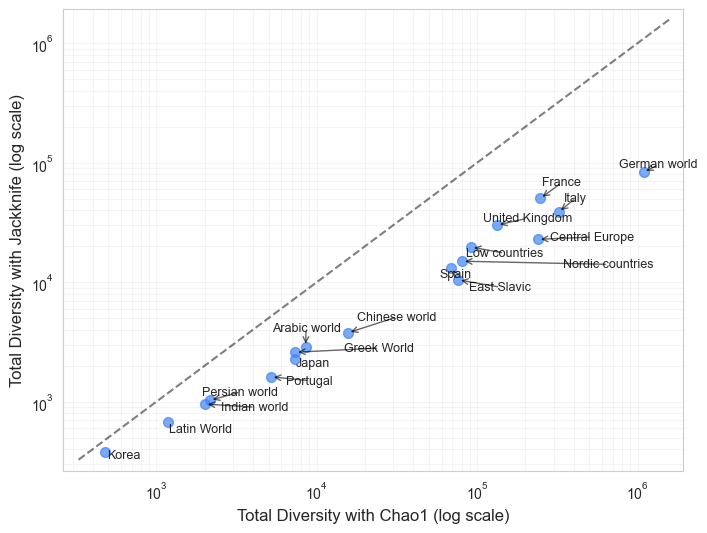

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  # This might need to be installed with pip install adjustText

# Filter out regions with "North" and "South" in their names
main_regions = [region for region in df_estimator['region_name'] 
               if not any(direction in region for direction in ["North", "South"])]
df_main = df_estimator[df_estimator['region_name'].isin(main_regions)]

# Create a figure for the log-scale scatter plot
plt.figure(figsize=(8, 6))  # Slightly larger figure to accommodate all labels

# Create scatter plot with larger points
scatter = plt.scatter(df_main['total_chao'], df_main['total_jackknife'], alpha=0.7, s=50, color='#4285F4')

# Set log scales for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Total Diversity with Chao1 (log scale)', fontsize=12)
plt.ylabel('Total Diversity with Jackknife (log scale)', fontsize=12)

# Add a reference line (where Chao = Jackknife)
max_val = max(df_estimator['total_chao'].max(), df_estimator['total_jackknife'].max())
min_val = min(df_estimator['total_chao'].min(), df_estimator['total_jackknife'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Create text annotations but don't add them yet
texts = []
for i, row in df_main.iterrows():
    texts.append(plt.text(row['total_chao'], row['total_jackknife'], row['region_name'], fontsize=9))

# Use adjust_text to prevent overlap
adjust_text(texts, 
           arrowprops=dict(arrowstyle='->', color='black', alpha=0.6),
           expand_points=(1.5, 1.5),
           force_points=(0.1, 0.1))

# Set axis limits with some padding
plt.xlim(min_val * 0.8, max_val * 1.2)
plt.ylim(min_val * 0.8, max_val * 1.2)

# Add grid for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Alternative approach if adjustText is not available:
# This manual approach uses specific positioning for problem regions



In [66]:
# compare chao1 and show that generalized chao is higher
# if not, it means that the model is not doing what it is supposed to do

In [67]:
d

NameError: name 'd' is not defined